## A/B Testing E-commerce Dataset

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates

url dataset = 'https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce'

This project will look for the relationship between shipping costs and buyer review rating values in determining the best sales strategy in e-commerce. Before that, it is necessary to determine a hypothesis for the possible results of the tests that will be carried out with the following details:
1. The null hypothesis (h0) means there is no relationship between shipping costs and buyer review ratings
2. The alternative hypothesis (ha) means that there is a relationship between shipping costs and buyer review ratings

### Import Library & Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#import the required datasets one by one
data1=pd.read_csv('olist_order_items_dataset.csv')
data2=pd.read_csv('olist_order_payments_dataset.csv')
data3=pd.read_csv('olist_order_reviews_dataset.csv')
data4=pd.read_csv('olist_orders_dataset.csv')
pd.set_option('display.max_columns', None)

In [3]:
print(f'data1 = {data1.columns}\n')
print(f'data2 = {data2.columns}\n')
print(f'data3 = {data3.columns}\n')
print(f'data4 = {data4.columns}')

data1 = Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

data2 = Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

data3 = Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

data4 = Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


### Preprocessing

In [4]:
#join multiple tables with foreign key column 'oder_id'
df=pd.merge(data1,data4,left_on='order_id', right_on='order_id')
df=pd.merge(df,data2,left_on='order_id', right_on='order_id')
df=pd.merge(df,data3.iloc[:,[1,2]],left_on='order_id',right_on='order_id')

In [5]:
display(df)

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
117324  fffc94f6ce00a00581880bf54a75a037              1   
117325  fffcd46ef2263f404302a634eb57f7eb              1   
117326  fffce4705a9662cd70adb13d4a31832d              1   
117327  fffe18544ffabc95dfada21779c9644f              1   
117328  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
117324  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
117325  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
117326  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
117327  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
117328  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  \
0       2017-09-19 09:45:35   58.90          13.29   
1       2017-05-03 11:05:13  239.90          19.93   
2       2018-01-18 14:48:30  199.00          17.87   
3       2018-08-15 10:10:18   12.99          12.79   
4       2017-02-13 13:57:51  199.90          18.14   
...                     ...     ...            ...   
117324  2018-05-02 04:11:01  299.99          43.41   
117325  2018-07-20 04:31:48  350.00          36.53   
117326  2017-10-30 17:14:25   99.90          16.95   
117327  2017-08-21 00:04:32   55.99           8.72   
117328  2018-06-12 17:10:13   43.00          12.79   

                             customer_id order_status  \
0       3ce436f183e68e07877b285a838db11a    delivered   
1       f6dd3ec061db4e3987629fe6b26e5cce    delivered   
2       6489ae5e4333f3693df5ad4372dab6d3    delivered   
3       d4eb9395c8c0431ee92fce09860c5a06    delivered   
4       58dbd0b2d70206bf40e62cd34e84d795    delivered   
...                                  ...          ...   
117324  b51593916b4b8e0d6f66f2ae24f2673d    delivered   
117325  84c5d4fbaf120aae381fad077416eaa0    delivered   
117326  29309aa813182aaddc9b259e31b870e6    delivered   
117327  b5e6afd5a41800fdf401e0272ca74655    delivered   
117328  96d649da0cc4ff33bb408b199d4c7dcf    delivered   

       order_purchase_timestamp    order_approved_at  \
0           2017-09-13 08:59:02  2017-09-13 09:45:35   
1           2017-04-26 10:53:06  2017-04-26 11:05:13   
2           2018-01-14 14:33:31  2018-01-14 14:48:30   
3           2018-08-08 10:00:35  2018-08-08 10:10:18   
4           2017-02-04 13:57:51  2017-02-04 14:10:13   
...                         ...                  ...   
117324      2018-04-23 13:57:06  2018-04-25 04:11:01   
117325      2018-07-14 10:26:46  2018-07-17 04:31:48   
117326      2017-10-23 17:07:56  2017-10-24 17:14:25   
117327      2017-08-14 23:02:59  2017-08-15 00:04:32   
117328      2018-06-09 17:00:18  2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-09-19 18:34:16           2017-09-20 23:43:48   
1               2017-05-04 14:35:00           2017-05-12 16:04:24   
2               2018-01-16 12:36:48           2018-01-22 13:19:16   
3               2018-08-10 13:28:00           2018-08-14 13:32:39   
4               2017-02-16 09:46:0

At this stage, compare transaction data that has shipping costs (freight value > 0) to transaction data that is free of shipping costs (freight value = 0). Random sampling is needed for transaction data that has shipping costs because it has a larger number of datasets than transaction data with free shipping costs, so the sampling process will follow the smallest number of dataset rows (downsampling).

Even though the sampling process is carried out randomly, the average value of transaction value in data that has shipping costs must be equal to or at least close to the average value in data that has free shipping costs.

In [8]:
#combine sampling data that has shipping costs with transaction data that has free shipping costs
data=df.copy()
data['shipping_cost']=np.where(data['freight_value']==0, 'Free Shipping', 'Add Shipping')

In [9]:
#check composition column shipping_cost
data.shipping_cost.value_counts()

Add Shipping     116940
Free Shipping       389
Name: shipping_cost, dtype: int64

In [10]:
#check duplicated value
print('duplicated : ', data.duplicated().sum())

#check null value
print('null :' , data['review_score'].isnull().sum())

duplicated :  419
null : 0


In [11]:
#drop data duplicated
data.drop_duplicates(inplace=True)

### Exploratory Analysis

In [12]:
#check mean and standard deviation each group
means = data.groupby('shipping_cost')['review_score']
std_p = lambda x: np.std(x, ddof=0)           
se_p = lambda x: stats.sem(x, ddof=0)
means = means.agg([np.mean, std_p, se_p])
means.columns = ['mean', 'std_deviation', 'std_error']
means.style.format('{:.3f}')
means

mean  std_deviation  std_error
shipping_cost                                    
Add Shipping   4.029857       1.388390   0.004067
Free Shipping  4.280206       1.215218   0.061614

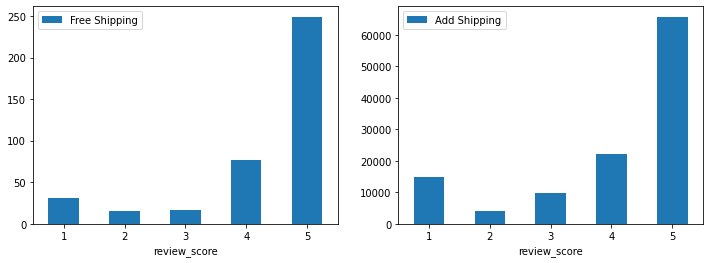

In [13]:
#show distribution review score each group
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
data[data.freight_value==0].groupby('review_score').size().plot.bar(label='Free Shipping')
plt.xticks(rotation = 0)
plt.legend()

plt.subplot(1, 2, 2)
data[data.freight_value>0].groupby('review_score').size().plot.bar(label='Add Shipping')
plt.xticks(rotation = 0)
plt.legend()
plt.show()

In [14]:
#generate dataframe for experiment with A/B Testing
data_test=pd.concat([data.groupby('shipping_cost')['review_score'].sum(),
           data.shipping_cost.value_counts()],axis=1)
data_test['conversion_rate']=data_test.review_score/data_test.shipping_cost
data_test

review_score  shipping_cost  conversion_rate
Add Shipping         469563         116521         4.029857
Free Shipping          1665            389         4.280206

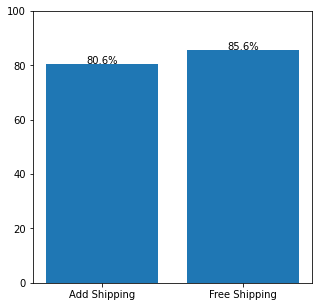

In [15]:
#visualization conversion rate (mean) with bar plot
x1=data_test.iloc[0,0]/5
n1=data_test.iloc[0,1]
x2=data_test.iloc[1,0]/5
n2=data_test.iloc[1,1]
x=['Add Shipping','Free Shipping']
y=[x1/n1,x2/n2]
y=list(np.around(np.array(np.array(y))*100,2))
plt.figure(figsize=(5,5))
plt.bar(x=x,height=y)
plt.ylim(0,100)
for i in range(len(x)):
    plt.text(i, y[i], s=f'{y[i]}%', ha = 'center')

Based on the data above, it shows that the conversion rate (mean) for transaction data with free shipping costs is greater than transaction data that has shipping costs. However, we cannot immediately conclude that the free shipping can affect the buyer review scores.

### Z-Test Proportional

The t-test step begins by finding whether there is a relationship between two variables with the p value indicator:
1. P-value > 0.05 will accept h0 and reject ha.
This means that there is no relationship between two variables. So the transaction strategy with free shipping will not affect the review score of the buyer
2. P-value <= 0.05 will accept ha and reject h0.
This means that there is a relationship between two variables. So the transaction strategy with free shipping can influence the review score of the buyer

In [16]:
#do a Z-test proportion to get the p-value
count = np.array([x1,x2])
nobs = np.array([n1,n2])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = -2.4938759820556546 
 p-value = 0.01263566840261157


The test results above show that the p-value shows a value of 0.0126 where the value is <= 0.05. This means that ha can be accepted and h0 will be rejected, so the shipping costs can influence the review score given by the buyer. Therefore, the results show that high conversion rate value in free shipping cost is very unlikely to be due to chance.